## Image Classification From Scratch
**https://keras.io/examples/vision/image_classification_from_scratch/**

In [1]:
# This example shows how to do image classification from scratch
# Starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application.

# We Use the image_dataset_from_directory

## Import Required Library

In [2]:
import os
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## For Plotting
import matplotlib.pyplot as plt

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9284941131169003718
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6910041152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10904263506469774421
physical_device_desc: "device: 0, name: GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [44]:
#  Setting Cuda visible devices to precisely -1 works
#os.environ["CUDA_VISBLE_DEVICES"] = '-1'

os.environ["CUDA_VISBLE_DEVICES"] = '-1'
if tf.test.gpu_device_name():
    print("GPU Found")
else:
    print("No GPU Found")

GPU Found


In [37]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


## Load Down load the data sets

In [6]:
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [7]:
# Check the Downloaded Data sets
#! ls
#!dir # This is Windows Machine

In [8]:
# In LInux environment
#!unzip -q kagglecatsanddogs_3367a.zip
#!dir

In [9]:
# In window i do manually Unzip and Move directory outside to datasets
os.listdir("../data_sets/")

['PetImages']

### Filter our Corrupted images

In [10]:
# When working with lots of real-world image data, Corrupted images are a common Occuracnces .
# Lets Filter out badly-encoded images

# Do-Not feature the string "JFIF" in their header


# Our Input datas are exists inside Pet Images
data_sets = "../data_sets/PetImages/" # Input data sets

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    # Cat and Dogs are folder inside data_sets
    folder_path = os.path.join(data_sets, folder_name) # Join Folder 
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally :
            fobj.close()
            
        if not is_jfif:
            num_skipped += 1
            # Delete Corrupted image
            os.remove(fpath)
print("Deleted %d images" %num_skipped)    

Deleted 0 images


### Genereate a Data set

In [11]:
print(data_sets)

../data_sets/PetImages/


In [12]:
image_size = (180,180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_sets ,
            validation_split=0.2,
            subset="training",
            seed = 1337,
            image_size = image_size,
            batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_sets,
            validation_split=0.2,
            subset="validation",
            seed = 1337,
            image_size = image_size,
            batch_size = batch_size,)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


## Visualize the data

In [13]:
lables_ = {0:"Cat", 1:"Dog"}
lables_[0]

'Cat'

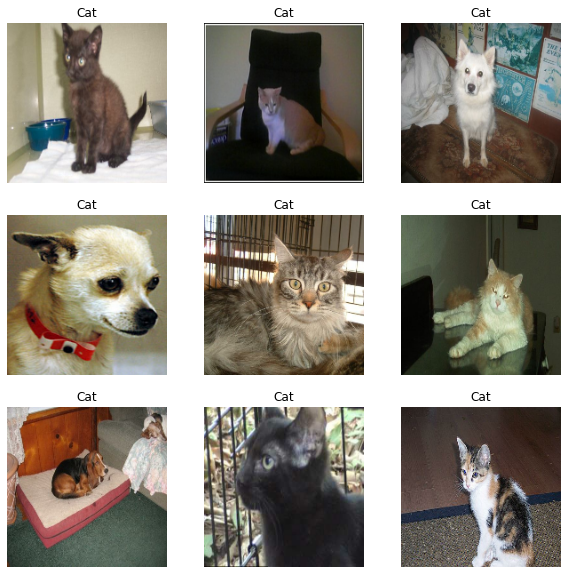

In [14]:
# Here are the firtst 9 images in the training dataset.
# As you can see, label 1 is Dog and label 0 is Cat

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1): # Iteration
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(lables_[int(labels[1])])
        plt.axis("off")

## Using image Data Augmentation

In [15]:
# Image Augmentation is a technique that is used to artificially expand the data-set.
# This is helpful when we are given a data-set with very few data samples.

# In case of Deep Learning , this situation  is bad as the model tends to over fit.
# when we train it on limited number of data samples.

# Image augmentation parameters that are generally used to increase the data sample.


# In General results in crease of existing data sample set by nearly 3X to 4X times.

In [16]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

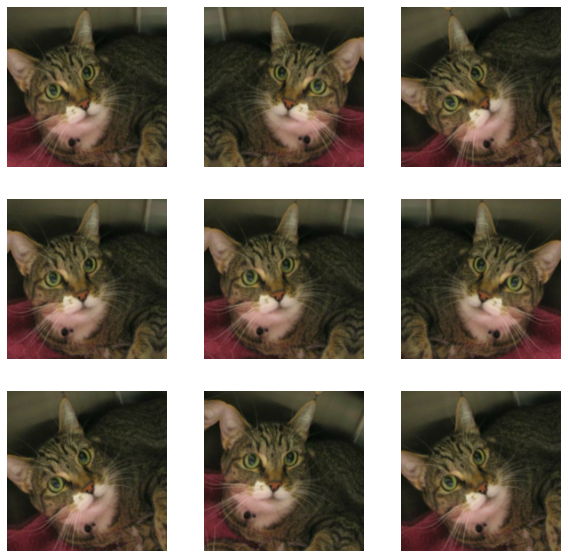

In [17]:
# Let's visualize what the augmented samples look like, by applying 
# data_augmentation repeatedly to the first image in the dataset

plt.figure(figsize=(10,10))
for images, axis in train_ds.take(1):
    for i in range(9):
        augmented_iamges = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        ax.imshow(augmented_iamges[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data
**Our images are already in standard size(180 X 180)** <br>

## Two options to preprocess the data
**There are two ways you could be using the data_augmentation preprocessor**

In [18]:
## Option 1 . Make it part of the model, like this

#inputs = keras.Input(shape=inpu_shape)
#x = data_augmentation(inputs)
#x = layers.experimental.preprocessing.Rescaling(1. / 255.)(x)

# Rest of the Model

# With this option , data augmentation will happen on device,
# synchronously with the rest  of the model execution , meaning that it will benefit from GPU acceleration.


# Note that dataaugmentation is inactive at test time,
# so the input samples will only be augmented during fit(),not when calling evaluate()

# If you're training on GPU, this is the better option

## Option 2 : Apply it to the dataset
**So as to obtain a dataset that yields batches of augmented images , like this**

In [19]:
augmented_train_ds = train_ds.map(
                        lambda x,y : (data_augmentation(x,training = True), y))

In [20]:
# With this option , data augmentation will happen on CPU, asynchronously
# and will be buffered before going into the model

# We have GPU so we will go through First Step 

### Configure the dataset for performance

In [21]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a Model
**We will build a small version of the Xception Network**

In [22]:
# We haven't tried to optimize the architecture 

# search more on Keras Tuner

# Note that:
    # We start the model with the data_augmentation preprocessor, follwed by a Rescalling layer
    # We include a Dropout layer before the final classification layer

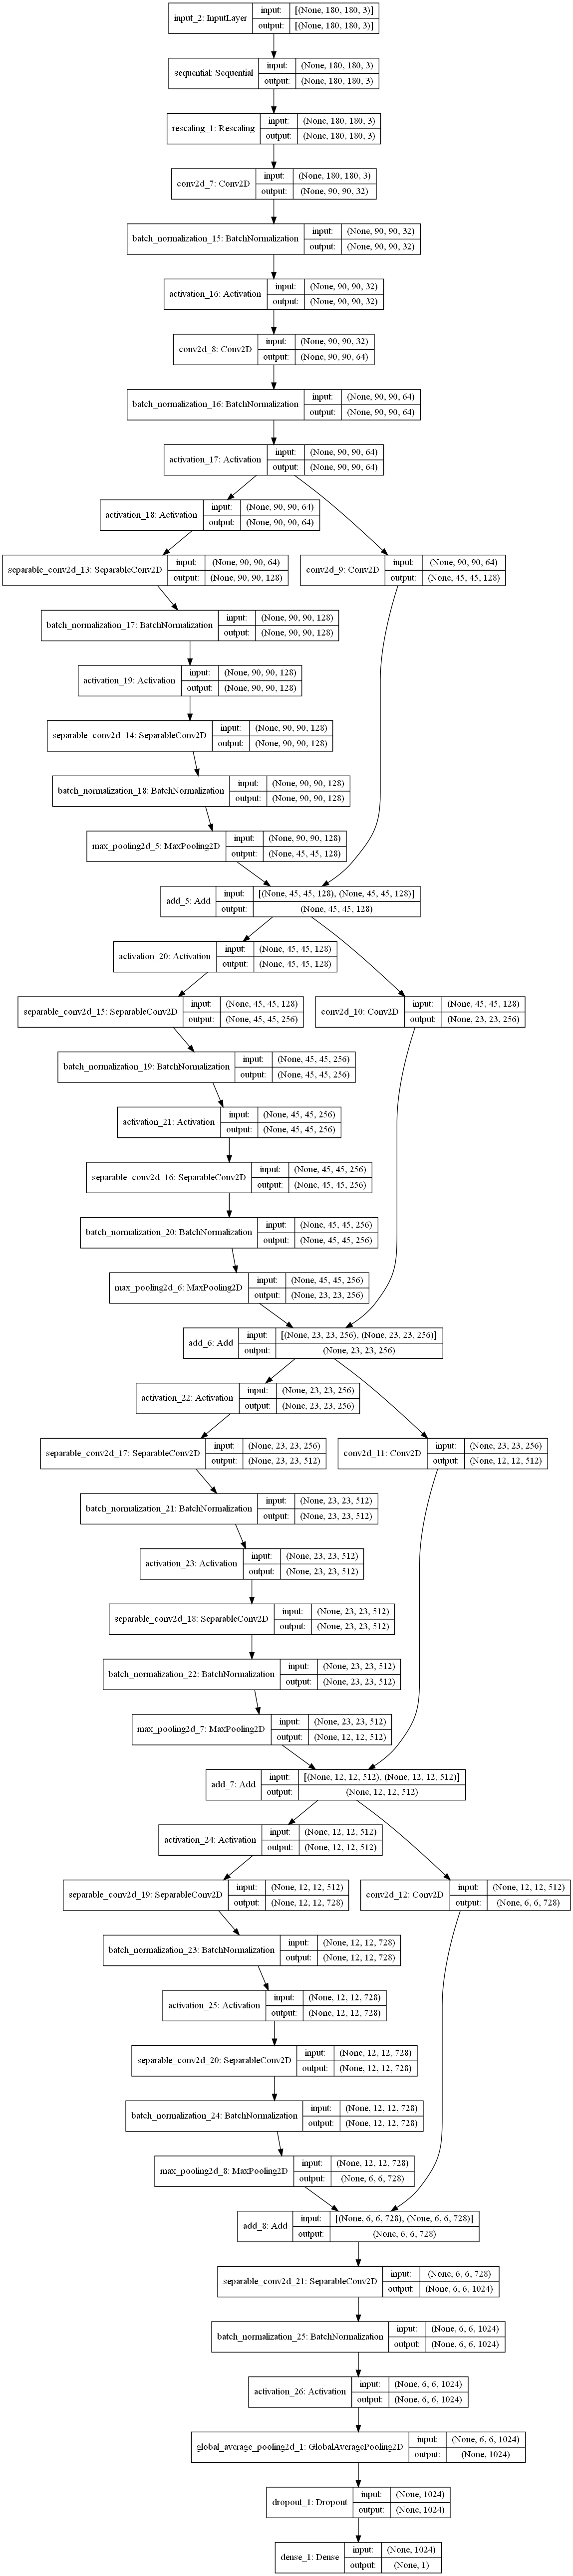

In [46]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the Model

In [47]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/conv2d_7/Conv2D (defined at <ipython-input-47-49bbab22d55e>:11) ]] [Op:__inference_train_function_14977]

Function call stack:
train_function


In [27]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Virtual devices cannot be modified after being initialized


In [28]:
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv2d/Conv2D (defined at <ipython-input-26-775772919380>:1) ]] [Op:__inference_train_function_6983]

Function call stack:
train_function
